# Hourly energy forecasting

## Time Series Analysis - hourly load forecasting

In [26]:
### Key points in analyzing time series
#Check for stationary series.
#constant mean, constant variance, autocorrelation that doesnt depend on time.
#Dickey Fuller test # tstaticstic is less than critical - reject null hypothesis.
#Make non-stationary to stationary - detrending, differencing.
#ARMA wont work with non-stationary series -> stationarize first.
#AR -> based on previous. Any sudden change is accounted immedialtely and slowly fades away.
#MA --> all sudden change is accounted immedialty and quickly subsides. so the correlation to t-n is low.
#I --> determines order of differenceing.
#Augmented dickey fueller test.
#ACF, PACF plots
#Can perform gridsearch for ARIMA parameters such that we get low AIC and BIC.


In [27]:
#Here I derived Hdd and Cdd from temperature. 

### Imports

In [3]:
#Imports
from pymongo import MongoClient
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn_pandas import DataFrameMapper


In [4]:
GroupId = "FDR_14442"
DBModelName = "PHI-model"
DBMeasurementsName = "PHI-measurements"

In [5]:
#convert timestamp in milliseconds to datetime
def tsmsToDate(ts):
    return datetime.datetime.fromtimestamp(ts/1000)

In [6]:
#set date format and convert string to datetime
fmt="%Y-%m-%d %H:%M"
def strToDate(str):
    return datetime.datetime.strptime(str,fmt)

In [7]:
#convert timestamp in milliseconds to datetime
def paramtoDate(y,m,d):
    dt= datetime.datetime(year=y, month=m, day=d)
    return time.mktime(dt.timetuple())

In [8]:
#Filter outliers around mean
def rejectOutliers(data, s =1.):
    flags = []
    stdev = np.std(data)
    mean = np.mean(data)
    slow = mean - s * stdev
    sup = mean + s * stdev
    for d in data:
        if d < slow or d > sup:
            flags.append(False)
        else:
            flags.append(True)
    return flags

In [9]:
#Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Read Consumption and Weather data

In [10]:
def readData(db):
    ## Read list of meters
    coll=db['model.e.meter.profile']
    docsProf = coll.find({"rateCode":"PMRS_R","groupId":GroupId})
    #Get meter ids for the desired group.
    listmid = []
    d = {'meterId':listmid}
    y = list(map(lambda dc : listmid.append(dc['meterId']), docsProf))
    dfMeters = pd.DataFrame(d)
    print(dfMeters.head())
    #Read meter interval data
    #Set database and collection 
    #Contains data only for feeder FDR_14442
    dfUsage = pd.DataFrame()
    db=client[DBMeasurementsName]
    coll=db['measurements.meter.daily.bag']
    #Query consumption data
    docsReads = coll.find({"meterId":{"$in":dfMeters['meterId'].values.tolist()}})
    print("Documents read:", docsReads.count())
    #Transform json documents into dataframe with consumption and timestamp.
    listDate = []
    listUsage = []
    meterId = []
    d = {'meterId':meterId, 'DataDate':listDate, 'Usage':listUsage}
    for doc in docsReads:
        intdata = doc['intervalData']
        for data in intdata:
            listDate.append(data[9])
            listUsage.append(data[0])
            meterId.append(doc['meterId'])
    dfUsage = pd.DataFrame(d)
    dfUsage.dropna()
    
    #Read weather data
    #read weather hourly data from csv
    path="/home/sravan/Dolphin/STLF/V1/"
    dfWeather = pd.read_csv(path+"weather_washington_reagan_airport.csv")
    return dfUsage, dfWeather

In [11]:
def processWeather(dfWeather):
    #Extract time and date features from weather data
    dfw = pd.DataFrame()
    dfw2 = pd.DataFrame()
    dfw['Date'] = dfWeather['Date'].apply(strToDate)
    dfw['Temperature'] = pd.to_numeric(dfWeather['Temperature'],errors='coerce')
#    dfw2['Hdd'] = pd.to_numeric(dfWeather['DAILYHeatingDegreeDays'],errors='coerce')
#    dfw2['Cdd'] = pd.to_numeric(dfWeather['DAILYCoolingDegreeDays'],errors='coerce')
    dfw = dfw.dropna()
    dtcol = dfw['Date'].dt
    dfw['year'] = dtcol.year
    dfw['month'] = dtcol.month
    dfw['daymonth'] = dtcol.day
    dfw['hour'] = dtcol.hour
    dfw['dayinweek'] = dtcol.weekday
    dfw2['year'] = dtcol.year
    dfw2['month'] = dtcol.month
    dfw2['daymonth'] = dtcol.day
    dfw2['hour'] = dtcol.hour
    dfwHourly = dfw.groupby(['year','month','daymonth','hour','dayinweek'])['Temperature'].mean().reset_index()
    dfwHourly = dfwHourly.dropna()
    print(dfwHourly.head(), dfwHourly.shape)
    return dfwHourly

In [12]:
def processUsage(dfUsage):
    print(dfUsage.head())
    #Extract time and date features from consumption data
    dfUsage['Date'] = dfUsage['DataDate'].apply(tsmsToDate)
    dtcol = dfUsage['Date'].dt
    dfUsage['year'] = dtcol.year
    dfUsage['month'] = dtcol.month
    dfUsage['daymonth'] = dtcol.day
    dfUsage['hour'] = dtcol.hour
    dfUsage['dayinweek'] = dtcol.weekday
    #Calculate daily total consumption for daily forecast
    dfUsageDaily = dfUsage.groupby(['year','month','daymonth','hour'])['Usage'].sum().reset_index()
    dfUsageDaily['Usage'] = dfUsageDaily['Usage']/1000
    #Filter outliers using standard deviation (on entire dataset)
    dfUsageDaily = dfUsageDaily[rejectOutliers(dfUsageDaily['Usage'])]

    print(dfUsageDaily.head(), dfUsageDaily.shape)
    return dfUsageDaily

### Create additional features

In [13]:
def createFeatures(df):
    
    #Encode weekday/weekend
    dff=pd.DataFrame()
    dff = df[df['year']==2013]
    dff = dff.append(df[df['year']==2014])
    df = dff.append(df[df['year']==2015])

    #df = df[df['month']==5]
    #df = df[df['daymonth']==11]
    df['Hdd'] = 65 - df['Temperature']
    df['Cdd'] = df['Temperature'] - 65
    df['Hdd'] = df['Hdd'].where(df['Hdd'] >= 0, 0)
    df['Cdd'] = df['Cdd'].where(df['Cdd'] >= 0, 0)
    #df['Cdd2'] = pow(df['Cdd'].values,2)
    #df['Cdd3'] = pow(df['Cdd'].values,3)

    df['weekend'] = np.array(df['dayinweek']>=5,dtype=int) 
    #Previous day load
    df['prevWkUsage'] = df['Usage'].shift(7*24)
    #df['prevDayUsage'] = df['Usage'].shift(24)
    #Diffs for 1 lag
    df['diffL1Usage'] = df['Usage'].shift(1) - df['Usage'].shift(2)
#    df['diffL1Temp'] = df['Temperature'].shift(1) - df['Temperature'].shift(2)
#    df['diffL1Hdd'] = df['Hdd'].shift(1) - df['Hdd'].shift(2)
#    df['diffL1Cdd'] = df['Cdd'].shift(1) - df['Cdd'].shift(2)
    #print(df[50:125])
    #Remove columns with NAN
    df = df.dropna()
    #separate input and target
    y = df['Usage']
    df = df.drop(['year','month','Usage','daymonth','dayinweek','Temperature'],axis=1)
    print("Columns:", df.columns)
    return df, y

In [14]:
def setupData(db):
    dfUsage, dfWeather = readData(db)
    print("setupData:Transforming data")
    #Put together consumption and weather data for same timestamps.
    dfUsage = processUsage(dfUsage)
    print("Usage:")
    print(dfUsage.head())

    dfW = processWeather(dfWeather)
    print("Weather:")
    print(dfW.head())
    df_full = pd.merge(dfUsage, dfW,  how='inner', on=['year','month','daymonth','hour'])
    return df_full
  

In [15]:
def setupFeatures(df, y):  
    #test-train split
    splitN = 24*7
    xtrain, xtest, ytrain, ytest = df.head(-splitN), df.tail(splitN), y.head(-splitN), y.tail(splitN)
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
    
    xtest = xtest.reset_index(drop=True);
    ytest = ytest.reset_index(drop=True);
    return xtrain, xtest, ytrain, ytest
    #scale prediction data
    #df_full = scaleFeatures(df_full, False)

## Main methods

### Read and setup data

In [16]:
#Create mongo client
client = MongoClient('localhost', 27017)
#Read meter profile
#Set database and collection
db=client[DBModelName]
df = setupData(db)
df, y = createFeatures(df)
print("creating features")
xtrain, xtest, ytrain, ytest = setupFeatures(df, y)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)


                              meterId
0  779433740600_21322002_4ED351147198
1  779433740600_21322018_4ED351147170
2  778432020130_21323010_NXA112087970
3  778432560950_21323100_1ND352779332
4  779432250030_21322270_NXA111192397
Documents read: 262526
setupData:Transforming data
        DataDate   Usage                             meterId
0  1420765200000  1047.6  776428360310_21351300_NXA112132261
1  1420768800000   639.6  776428360310_21351300_NXA112132261
2  1420772400000   635.4  776428360310_21351300_NXA112132261
3  1420776000000   712.2  776428360310_21351300_NXA112132261
4  1420779600000   609.6  776428360310_21351300_NXA112132261
      year  month  daymonth  hour       Usage
3312  2013      5        20    21  397.999271
3313  2013      5        20    22  323.167905
3314  2013      5        20    23  284.737692
3315  2013      5        21     0  271.688837
3316  2013      5        21     1  256.874591 (13635, 5)
Usage:
      year  month  daymonth  hour       Usage
3312  2013     

### Create pipelines

In [17]:
def createPipelines():
    scalCols = ['Hdd','Cdd', 'diffL1Usage', 'prevWkUsage']
    encodCols = ['hour','weekend']
    mapper = DataFrameMapper([(d, LabelEncoder()) for d in encodCols])
    funion = FeatureUnion([('categorical',Pipeline([('mapper', mapper), ('onehot', OneHotEncoder())])), 
                       ('scaler',StandardScaler(scalCols))])
    pipe_lr = Pipeline([('funion', funion),('regressor',LinearRegression())])
    pipe_mlpr = Pipeline([('funion', funion),('regressor',MLPRegressor())])
    pipe_mlpr.set_params(regressor__hidden_layer_sizes=(10),regressor__solver='lbfgs')
    pipe_gbr = Pipeline([('funion', funion),('regressor',GradientBoostingRegressor())])

    pipes = {"Linear":pipe_lr,"MLP":pipe_mlpr, "GradientBoosting":pipe_gbr}
    return pipes

### Fit training data


In [18]:
models = {}
pipes = createPipelines()
#print(pipes)
for pipe, est in enumerate(pipes):
    print(est)
    model = pipes[est].fit(xtrain, ytrain)
    print(model)
    models[est] = model

Linear
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('hour', LabelEncoder()), ('weekend', LabelEncoder())],
        input_df=False, sparse=False)), ('onehot', One...None)), ('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
MLP
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('hour', LabelEncoder()), ('weekend', LabelEncoder())],
        input_df=False, sparse=False)), ('onehot', One...True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])
GradientBoosting
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical',

## Predict
### API for predict

In [19]:
ypredicts = {}
def forecast(df):
    for model in models:
        print(model)
        ypredict = models[model].predict(df)
        mape = mean_absolute_percentage_error(ytest, ypredict)
        ypredicts[model] = ypredict
        print("MAPE for %s "%model, ":%f" %mape)
        #Test data against predicted data
        plt.figure(figsize=(10,4))
        plt.title(model)
        plt.plot(ytest, label = 'test')
        plt.plot(ypredict, label = 'predicted')
        ax =plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.grid('on')
    
      


,hour,Hdd,Cdd,weekend,prevWkUsage,diffL1Usage
168,19,0.0,6.0,0,397.999271,19.477958
169,20,0.0,5.0,0,323.167905,-63.978416
170,21,0.0,5.0,0,284.737692,-153.023419
171,22,0.0,5.0,0,271.688837,-89.466474
172,23,0.0,5.0,0,256.874591,-36.690067


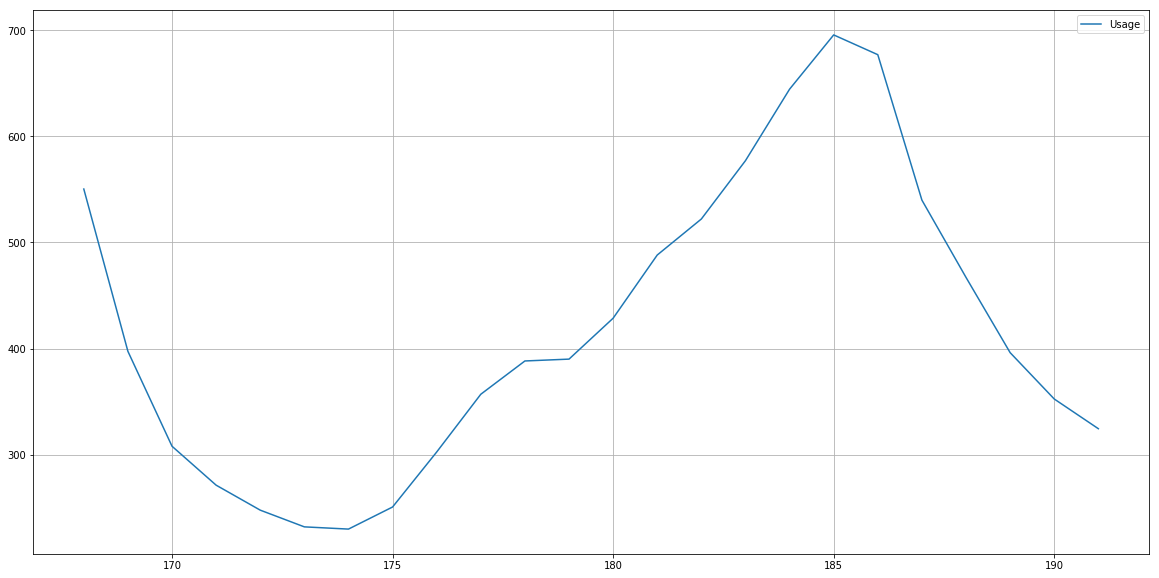

In [20]:
plt.figure(figsize=(20,10))
#plt.plot(xtrain['sig'],color='g', label = 'fftSignal')
#plt.plot(xtrain['Hdd'],color='r', label = 'Hdd')
#plt.plot(xtrain['Cdd'],color='b', label = 'Cdd')
#plt.plot(xtrain['Temperature']/10,color='y', label = 'Temperature')
plt.plot(ytrain[0:24], label = 'Usage')
ax =plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.grid('on')
xtrain.head()

Linear
MAPE for Linear  :7.641023
MLP
MAPE for MLP  :7.774447
GradientBoosting
MAPE for GradientBoosting  :7.107856


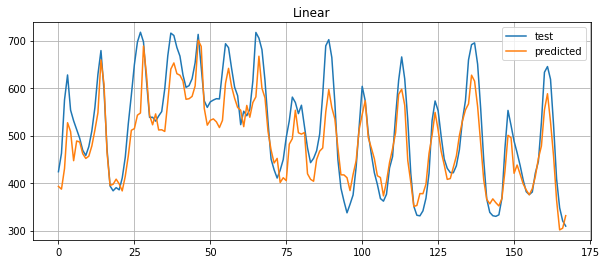

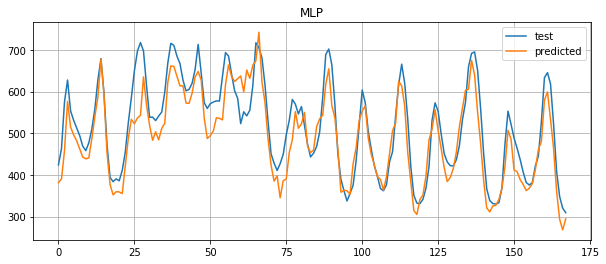

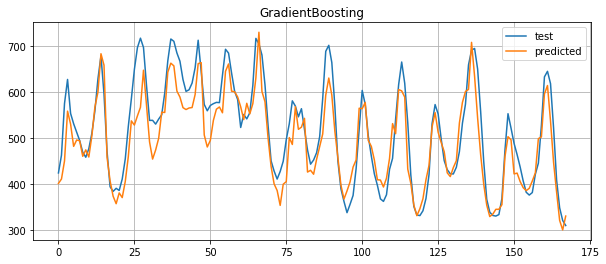

In [21]:
forecast(xtest)

from flask import Flask, jsonify, request
app = Flask(__name__)
@app.route('/predict', methods=['POST'])
def apicall():
    try:
        print("Getting json")
        test_json = request.get_json()
        test = pd.read_json(test_json, orient='records') 
    except Exception as e:
        raise e 
    if test.empty:
        return(bad_request())
    else:
        print("Predicting")
        predictions = forecast(test)
        predictions = pd.DataFrame(predictions)
        responses = jsonify(predictions=predictions.to_json(orient="records"))
        responses.status_code = 200
        return(responses)

### API for fit

In [22]:
def createModels(predictorsDf, targetY):
    xtrain, xtest, ytrain, ytest = setupFeatures(predictorsDf, targetY)
    pipes = createPipelines()
    models = {}
    #print(pipes)
    for pipe, est in enumerate(pipes):
        print(est)
        model = pipes[est].fit(xtrain, ytrain)
        print(model)
        models[est] = model
    return models

In [23]:
models = createModels(df, y)

(12822, 6) (168, 6) (12822,) (168,)
Linear
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('hour', LabelEncoder()), ('weekend', LabelEncoder())],
        input_df=False, sparse=False)), ('onehot', One...None)), ('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
MLP
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('hour', LabelEncoder()), ('weekend', LabelEncoder())],
        input_df=False, sparse=False)), ('onehot', One...True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])
GradientBoosting
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
    

In [24]:
ypredicts = {}
def forecast(df, models):
    for model in models:
        print(model)
        ypredict = models[model].predict(df)
        mape = mean_absolute_percentage_error(ytest, ypredict)
        ypredicts[model] = ypredict
        print("MAPE for %s "%model, ":%f" %mape)
        #Test data against predicted data
        plt.figure(figsize=(10,4))
        plt.title(model)
        plt.plot(ytest, label = 'test')
        plt.plot(ypredict, label = 'predicted')
        ax =plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.grid('on')

Linear
MAPE for Linear  :7.641023
MLP
MAPE for MLP  :7.852212
GradientBoosting
MAPE for GradientBoosting  :7.107856


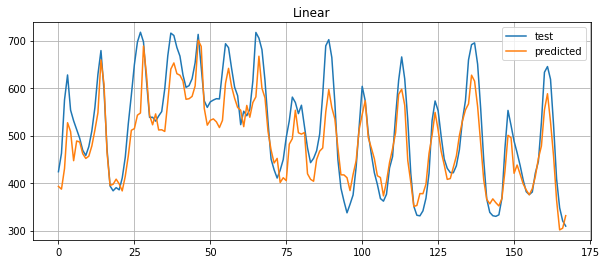

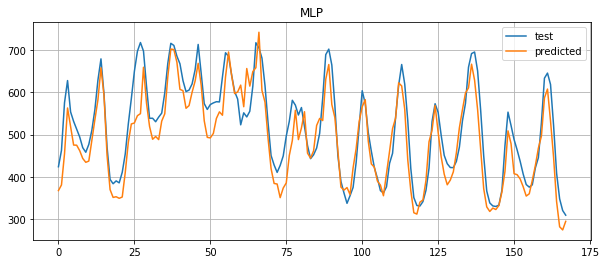

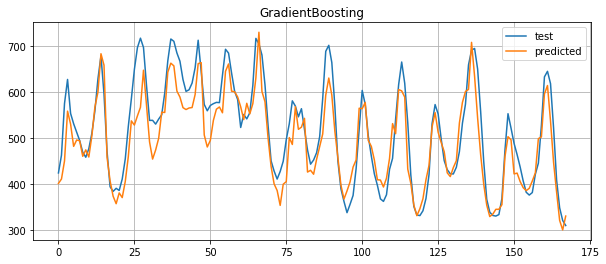

In [25]:
yForecast = forecast(xtest, models)